## Раздел II. Обогащение данных 

__В задачи этого этапа входит добавление к исследуемому набору дополнительных показателей , а также извлечение из имеющихся дополнительной информации, необходимой для построения модели__

__Рабочим__ набором является датафрейм 'orders', который содержит обобщенные данные о продажах по покупателям


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
# загрузим рабочий набор, созданный на 1-м этапе 
orders = pd.read_csv('orders_1.csv', low_memory=False)

In [4]:
# импортируем из вспомогателього модуля 'my_utils' класс для работы с orders
from my_utils import Order

# создадим объект
obj_orders = Order(orders)

### a)  каждая накладная имеет важные характеристики - номенклатура приобретенных товаров (кол-во строк накладной)  и суммарное кол-во приобретенных товаров
#### Извлечем эту информацию из первичного набора 'tickets' и присоединим  к рабочему датафрейму два новых поля:

- __LINES_QTY__ - количество строк в накладной (номенклатура товаров)
- __ITEMS_QTY__ - всего количество товаров

In [5]:
# загрузить `tickets`
tickets = pd.read_csv('tickets.csv', low_memory=False)

In [6]:
# подсчитаем количество строк в каждой накладной
ticket_lines = tickets.groupby(['SA_HDR_TIC'])['SA_HDR_TIC'].count()

In [7]:
# подсчитаем количество товаров в каждой накладной
ticket_qty = tickets.groupby(['SA_HDR_TIC'])['SA_LIN_QTY'].sum()

In [8]:
print ticket_lines.shape, ticket_qty.shape

(124729,) (124729,)


In [9]:
# конвертируем в dataframe, чтобы слить с основной таблицей
ticket_lines_df = pd.DataFrame(ticket_lines)
ticket_qty_df = pd.DataFrame(ticket_qty)

In [10]:
# присоединим к исследуемому набору новые колонки признаков
orders = pd.merge(orders, ticket_lines_df, left_on='SA_HDR_TIC', right_index=True)
orders = pd.merge(orders, ticket_qty_df, left_on='SA_HDR_TIC', right_index=True, sort=True)

In [11]:
# переименуем присоединенные колонки
orders.rename(columns={'SA_HDR_TIC_y':'LINES_QTY', 'SA_LIN_QTY': 'ITEMS_QTY'}, inplace=True)

In [12]:
# удалим лишние колонки
orders.drop(['SA_HDR_TIC_x', 'CUST_NO_L6'], inplace=True, axis=1)

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124777 entries, 54180 to 54179
Data columns (total 13 columns):
SA_HDR_TIC    124777 non-null int64
CUST_NAM      124776 non-null object
SA_HDR_DAT    124777 non-null object
SA_HDR_AMT    124777 non-null float64
CUST_CAT      103709 non-null object
CUST_PROFI    124777 non-null float64
CUST_PRO01    124777 non-null float64
CUST_PRO02    124777 non-null float64
CUST_PRO03    124777 non-null float64
CUST_PRO04    124777 non-null float64
CUST_PRO05    124777 non-null float64
LINES_QTY     124777 non-null int64
ITEMS_QTY     124777 non-null float64
dtypes: float64(8), int64(2), object(3)
memory usage: 13.3+ MB


In [14]:
# видим, что одна строка набора не имеет имени покупателя - удалим ее
orders.dropna(axis=0, subset=['CUST_NAM'], inplace=True)

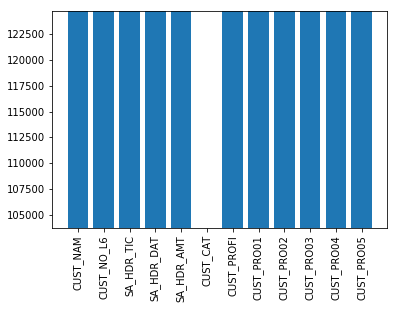

In [15]:
obj_orders.futures_dist()

### б) из набора customers извлечем дополнительную информацию о характеристиках покупателей (город, zip-код, и т.д)



In [16]:
customers = pd.read_csv('customers.csv')

In [17]:
customers.columns

Index([u'Unnamed: 0', u'CUST_NO_L6', u'CUST_NAM_U', u'CUST_ZIP_C',
       u'CUST_ADRS_', u'CUST_CITY', u'CUST_PHONE', u'CUST_ADR01',
       u'CUST_BAL_M', u'CUST_CR_LI', u'CUST_PHO01', u'CUST_CONTC',
       u'CUST_CON01', u'CUST_TYP', u'CUST_LST_P', u'CUST_LST01', u'CUST_BAL',
       u'CUST_COMMN', u'CUST_CAT'],
      dtype='object')

In [18]:
# сформируем список показателей для последующего анализа
customer_fields_to_merge = ['CUST_NAM_U', 'CUST_ZIP_C', 'CUST_CITY',
                           'CUST_LST_P','CUST_LST01','CUST_BAL']

In [19]:
# присоединим эти колонки к основному датафрейму по ключу 'CUST_NAM'
orders = pd.merge(orders, customers[customer_fields_to_merge], left_on='CUST_NAM', 
         right_on='CUST_NAM_U', how='left')

In [20]:
orders = orders.drop('CUST_NAM_U', axis=1)

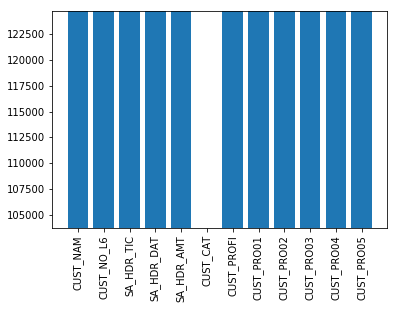

In [21]:
obj_orders.futures_dist()

### в). введем признаки, характеризующие покупателя
- __CUST_RET_QTY__ - кол-во возвратов
- __CUST_RET_SUM__ - общая сумма возвратов
               
*возвраты* - это отрицательное значение поля __SA_HDR_AMT__

In [22]:
orders[orders.SA_HDR_AMT < 0].head(3)

,SA_HDR_TIC,CUST_NAM,SA_HDR_DAT,SA_HDR_AMT,CUST_CAT,CUST_PROFI,CUST_PRO01,CUST_PRO02,CUST_PRO03,CUST_PRO04,CUST_PRO05,LINES_QTY,ITEMS_QTY,CUST_ZIP_C,CUST_CITY,CUST_LST_P,CUST_LST01,CUST_BAL
63,1062,Walk-in,2005-09-06,-44.58,PA,0.0,0.00,0.00,0.0,0.0,0.0,1,-1.0,NaN,NaN,NaN,NaN,NaN
187,1184,METRO TOBACCO JUNCTION,2005-09-22,-870.40,PH,2.0,1.75,1.25,0.0,0.0,0.0,5,-20.0,19152,PHILADELPHIA,2015-10-28,3328.95,16.55
235,1231,52STR. A PLUS SUNOCO,2005-10-21,-3002.88,PH,3.1,2.75,2.75,0.0,0.0,0.0,7,-69.0,19143,PHILADELPHIA,2014-04-11,3077.33,-2413.30


In [23]:
# произведем расчет в вспомогательный датафрейм, содержащий для каждого покупателя
# его имя, кол-во и сумму возвратов за весь период

returned_orders = orders[orders.SA_HDR_AMT < 0] \
    .groupby(['CUST_NAM'])['SA_HDR_AMT'].agg(['count','sum'])
returned_orders.head(3)

,count,sum
CUST_NAM,,
11-TH STR. MOBIL,9,-7889.25
130 LIQUOR,22,-2063.78
1803 TORRESDALE BP,5,-1162.27


In [24]:
# присоединим этот набор к рабочему датафрейму
orders = pd.merge(orders, returned_orders, left_on='CUST_NAM', how='left', right_index=True)

In [25]:
# переименуем новые признаки
orders = orders.rename(columns={'count': 'CUST_RET_QTY', 'sum': 'CUST_RET_SUM'})

In [26]:
orders[['CUST_RET_QTY', 'CUST_RET_SUM']].head(5)

,CUST_RET_QTY,CUST_RET_SUM
0,7.0,-1054.87
1,1.0,-135.84
2,NaN,NaN
3,56.0,-9939.68
4,1.0,-60.80


In [27]:
orders[['CUST_RET_QTY', 'CUST_RET_SUM']] = orders[['CUST_RET_QTY', 'CUST_RET_SUM']].fillna(0)

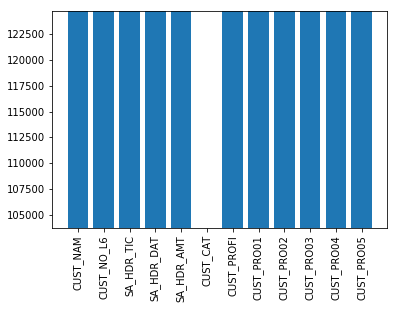

In [28]:
obj_orders.futures_dist()

In [29]:
orders.head()

,SA_HDR_TIC,CUST_NAM,SA_HDR_DAT,SA_HDR_AMT,CUST_CAT,CUST_PROFI,CUST_PRO01,CUST_PRO02,CUST_PRO03,CUST_PRO04,CUST_PRO05,LINES_QTY,ITEMS_QTY,CUST_ZIP_C,CUST_CITY,CUST_LST_P,CUST_LST01,CUST_BAL,CUST_RET_QTY,CUST_RET_SUM
0,1000,ARAMINGO GULF,2005-08-16,3916.80,PH,3.00,2.10,1.80,0.0,0.0,0.0,5,90.0,19124,PHILADELPHIA,2016-12-20,5172.48,5489.71,7.0,-1054.87
1,1001,HARRYS AMOCO,2005-08-16,2959.36,RG,2.00,1.50,1.50,0.0,0.0,0.0,8,68.0,19151,PHILADELPHIA,2008-06-02,828.80,0.00,1.0,-135.84
2,1002,WOODLYN MOBIL,2005-08-16,1653.76,1,2.00,1.25,1.10,0.0,0.0,0.0,8,38.0,19094,WOODLYN,2007-08-16,94.38,0.00,0.0,0.00
3,1003,SAIMART INC.,2005-08-16,565.76,PA,3.65,3.00,2.65,0.0,0.0,0.0,7,13.0,19320,COATSEVILLE,2016-12-28,5153.07,10011.87,56.0,-9939.68
4,1004,SUNOCO NORWOOD,2005-08-16,826.88,PL,2.00,1.25,1.10,0.0,0.0,0.0,4,19.0,19074,NORWOOD,2008-03-14,96.60,0.00,1.0,-60.80


### г). рассчитаем признаки, характеризующие лояльность и доходность покупателя

- __CUST_TIME_DEAL__ -  время, в течение которого покупатель приобретал товары (месяцах)

Рассчитывается, как разность между последней и 1-й покупкой
- __CUST_TOTAL_AMT__ - сумма, товаров купленных покупателем за весь период сотрудничества (с учетом возвратов)

Рассчитывается, как сумма по полю SA_HDR_AMT для покупателя 

In [30]:
# для выполнения расчетов преобразуем поле даты из строки в тип 'дата'
orders.SA_HDR_DAT = pd.to_datetime(orders.SA_HDR_DAT)

In [31]:
# создадим временный датафрейм с мин. и мак. временем накладной по каждому покупателю
min_max = orders.groupby(by="CUST_NAM")['SA_HDR_DAT'].agg(['min', 'max'])
min_max.head(5)

,min,max
CUST_NAM,,
11-TH STR. MOBIL,2005-09-12,2008-03-12
130 LIQUOR,2008-06-26,2016-12-29
1803 TORRESDALE BP,2010-05-10,2011-12-23
28TH ST. MINI MARKET,2011-07-06,2012-08-15
29@30 SUNOCO,2012-05-30,2012-06-13


In [32]:
# подсчитаем разность
min_max['CUST_TIME_DEAL'] = (min_max['max'] - min_max['min'])

In [33]:
# присоединим признак CUST_TIME_DEAL к основному датафрейму
orders = pd.merge(orders, pd.DataFrame(min_max.CUST_TIME_DEAL), left_on='CUST_NAM',
         right_index=True, how='left')

In [34]:
# перобразуем CUST_TIME_DEAL в дни 
orders.CUST_TIME_DEAL = orders.CUST_TIME_DEAL.dt.days

In [35]:
# рассчитаем общую сумму покупок по покупателям в вспомогательный набор
amt = orders.groupby(by="CUST_NAM")['SA_HDR_AMT'].agg(['sum'])
amt.head()

,sum
CUST_NAM,
11-TH STR. MOBIL,315286.42
130 LIQUOR,775525.14
1803 TORRESDALE BP,318950.16
28TH ST. MINI MARKET,111492.34
29@30 SUNOCO,1703.16


In [36]:
# присоединим признак CUST_TIME_DEAL к основному датафрейму
orders = pd.merge(orders, amt, left_on='CUST_NAM',
         right_index=True, how='left')

orders.rename(columns={'sum': 'CUST_TOTAL_AMT'}, inplace=True)

In [37]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179259 entries, 0 to 179258
Data columns (total 22 columns):
SA_HDR_TIC        179259 non-null int64
CUST_NAM          179259 non-null object
SA_HDR_DAT        179259 non-null datetime64[ns]
SA_HDR_AMT        179259 non-null float64
CUST_CAT          141412 non-null object
CUST_PROFI        179259 non-null float64
CUST_PRO01        179259 non-null float64
CUST_PRO02        179259 non-null float64
CUST_PRO03        179259 non-null float64
CUST_PRO04        179259 non-null float64
CUST_PRO05        179259 non-null float64
LINES_QTY         179259 non-null int64
ITEMS_QTY         179259 non-null float64
CUST_ZIP_C        178616 non-null object
CUST_CITY         178617 non-null object
CUST_LST_P        178006 non-null object
CUST_LST01        178655 non-null float64
CUST_BAL          178655 non-null float64
CUST_RET_QTY      179259 non-null float64
CUST_RET_SUM      179259 non-null float64
CUST_TIME_DEAL    179259 non-null int64
CUST_TOTAL_

### д). добавить признак - день недели (номер), в который совершена покупка

__SA_HDR_DOW__ - день недели, когда была сделана покупка 

In [38]:
# добавим признак в дадасет
orders['SA_HDR_DOW'] = orders.SA_HDR_DAT.dt.dayofweek

In [39]:
group_by_dow = orders.groupby(by='SA_HDR_DOW')
print(group_by_dow.SA_HDR_TIC.agg('count'))

SA_HDR_DOW
0    47299
1    43791
2    36101
3    39696
4    12316
5       46
6       10
Name: SA_HDR_TIC, dtype: int64


In [40]:
# сохраним рабочий набор для следующего этапа
orders.to_csv('orders_2-1.csv', index=False)